In [14]:
import cv2
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import torch
from torchvision.transforms import functional as F

   image_id    x    y  orientation  radius  class
0         0  269  450     0.000000      17      0
1         0  533  299     0.663225      45      1
2         0  539  427     0.610865      46      1
3         0  365  148     0.488692      45      1
4         0  472  136     2.426008      40      1


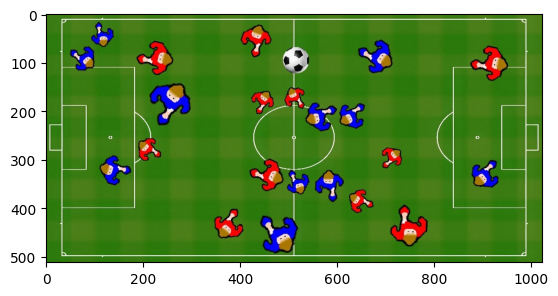

In [2]:
# Assuming you have a function to load images by image_id
def load_image(image_id):
    # Replace this with the actual path to your images and the method to load them
    image_path = f'easy-500/0.jpg'
    return Image.open(image_path)

# Visualize an example with bounding circles
def visualize_example(image_id):
    image = load_image(image_id)
    data = labels_df[labels_df['image_id'] == image_id]
    draw = ImageDraw.Draw(image)
    for _, row in data.iterrows():
        # Calculate the bounding circle
        left = row['x'] - row['radius']
        top = row['y'] - row['radius']
        right = row['x'] + row['radius']
        bottom = row['y'] + row['radius']
        draw.ellipse([left, top, right, bottom], outline='red')
    
    plt.imshow(image)
    plt.show()

# Example visualization
visualize_example('example_image_id')

In [116]:
# Define a data augmentation pipeline
from torchvision import transforms

data_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=45),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=10),
    transforms.ToTensor()  # Convert back to tensor for model input
])

In [65]:
# Dataset preparation for PyTorch

class FootballDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, image_dir, S=7, B=1, C=3, transform=None, new_size=(416, 416)):
        """
        - dataframe: The DataFrame containing the labels.
        - image_dir: Directory where images are stored.
        - S: Size of the grid (SxS).
        - B: Number of bounding boxes per grid cell.
        - C: Number of classes (3 in your case: ball, team 1 player, team 2 player).
        - transform: Any transformations to apply to the images.
        """
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.S = S
        self.B = B
        self.C = C
        self.transform = transform
        self.new_size = new_size
    
    def __len__(self):
        return len(self.dataframe['image_id'].unique())
    
    def __getitem__(self, idx):
        image_id = self.dataframe['image_id'].unique()[idx]
        image = load_image(image_id)
        #image = cv2.imread(f'easy-500/0.jpg')
        #image = cv2.imread(self.image_dir + self.dataframe['image_id'].iloc[idx])


        # Load and resize the image, then get its new dimensions
        #image_path = self.image_dir + self.dataframe['image_id'].iloc[idx]
        image = cv2.imread(f'easy-500/0.jpg')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        original_height, original_width = image.shape[:2]
        image = cv2.resize(image, self.new_size, interpolation=cv2.INTER_LINEAR)
        new_height, new_width = self.new_size
    
        # Scaling factors for the labels
        x_scale = new_width / original_width
        y_scale = new_height / original_height
    
        # Process labels
        data = self.dataframe[self.dataframe['image_id'] == self.dataframe['image_id'].iloc[idx]]
        labels = torch.zeros((self.S, self.S, self.B * 5 + self.C))
    
        for _, row in data.iterrows():
            # Adjust labels for the scaled image size
            x = row['x'] * x_scale
            y = row['y'] * y_scale
            radius = row['radius'] * max(x_scale, y_scale)
            
            # Calculate grid cell indices
            grid_x = int(x // (new_width / self.S))
            grid_y = int(y // (new_height / self.S))
            
            # Calculate the position of the object within its grid cell
            cell_x = (x % (new_width / self.S)) / (new_width / self.S)
            cell_y = (y % (new_height / self.S)) / (new_height / self.S)
            
            # Calculate normalized radius relative to the cell size
            cell_radius = radius / (new_width / self.S)
    
            # Assign label data to the corresponding grid cell
            if grid_x < self.S and grid_y < self.S:
                labels[grid_x, grid_y, 0] = 1  # Object presence
                labels[grid_x, grid_y, 1] = cell_x
                labels[grid_x, grid_y, 2] = cell_y
                labels[grid_x, grid_y, 3] = cell_radius
                labels[grid_x, grid_y, 4] = row['orientation'] / (2 * np.pi)
                # One-hot encoding of the class
                labels[grid_x, grid_y, 5 + int(row['class'])] = 1
    
         #Convert the image to a PyTorch tensor and normalize to the range [0, 1]
        image_tensor = transforms.ToTensor()(image)
        
        # Apply data transformations/augmentations
        if self.transform:
            image = data_transforms(image)

        # Return the image and labels
        return image_tensor, labels
        

In [66]:
# Assuming images are in 'path/to/images' and transform is to be defined
dataset = FootballDataset(labels_df, 'easy-500/0.jpg')

# Example to get an item from the dataset
image, labels = dataset[0] 

In [67]:
image

tensor([[[0.2275, 0.2275, 0.2235,  ..., 0.2863, 0.2902, 0.2902],
         [0.2314, 0.2235, 0.2275,  ..., 0.2941, 0.2902, 0.2902],
         [0.2353, 0.2235, 0.2275,  ..., 0.2902, 0.2902, 0.2941],
         ...,
         [0.1686, 0.1686, 0.1686,  ..., 0.2235, 0.2275, 0.2235],
         [0.1725, 0.1686, 0.1686,  ..., 0.2275, 0.2275, 0.2235],
         [0.1686, 0.1647, 0.1686,  ..., 0.2275, 0.2235, 0.2196]],

        [[0.4863, 0.4863, 0.4824,  ..., 0.4902, 0.4902, 0.4902],
         [0.4863, 0.4824, 0.4863,  ..., 0.4941, 0.4902, 0.4902],
         [0.4902, 0.4863, 0.4863,  ..., 0.4902, 0.4902, 0.4941],
         ...,
         [0.4784, 0.4745, 0.4745,  ..., 0.4824, 0.4863, 0.4784],
         [0.4784, 0.4745, 0.4745,  ..., 0.4863, 0.4863, 0.4824],
         [0.4745, 0.4706, 0.4745,  ..., 0.4902, 0.4824, 0.4784]],

        [[0.0706, 0.0706, 0.0667,  ..., 0.0902, 0.0941, 0.0941],
         [0.0706, 0.0667, 0.0706,  ..., 0.0980, 0.0941, 0.0941],
         [0.0784, 0.0667, 0.0706,  ..., 0.0941, 0.0941, 0.

In [69]:
import random

def transform_labels_for_flip(labels, image_width):
    # Flip bounding box coordinates horizontally
    labels[:, 1] = 1 - labels[:, 1]  # Assuming the x coordinate is at index 1
    return labels

# In your __getitem__ method, check if a horizontal flip was applied
if random.random() > 0.5:
    image = transforms.functional.hflip(image)
    labels = transform_labels_for_flip(labels, new_width)


In [ ]:
2. 

In [70]:
import torch
import torch.nn as nn
from torchvision import models


In [72]:
class YOLODetector(nn.Module):
    def __init__(self, grid_size, num_bounding_circles, num_classes):
        super(YOLODetector, self).__init__()
        self.grid_size = grid_size
        self.num_bounding_circles = num_bounding_circles
        self.num_classes = num_classes

        # Define a CNN backbone, e.g., ResNet-18
        backbone = models.resnet18(pretrained=True)
        self.features = nn.Sequential(*list(backbone.children())[:-2])  # Exclude the avgpool and fc layers
        
        # Detection layer to predict bounding circles and classes
        # For each bounding circle, predict (x, y, radius, confidence, orientation) and class scores
        self.detection = nn.Conv2d(
            in_channels=512,  # Matches the feature output of ResNet-18
            out_channels=self.grid_size * self.grid_size * (5 + self.num_classes) * self.num_bounding_circles,
            kernel_size=1
        )
        
        # Activation function to use after the detection layer
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # Feature extraction
        x = self.features(x)
        
        # Bounding circle detection
        x = self.detection(x)
        
        # Reshape the detections to the expected output format
        x = x.view(-1, self.grid_size, self.grid_size, self.num_bounding_circles, (5 + self.num_classes))
        
        # Apply the sigmoid activation to the confidence score, class scores, and orientation
        x[..., 3] = self.sigmoid(x[..., 3])  # Confidence score
        x[..., 4] = self.sigmoid(x[..., 4])  # Orientation
        x[..., 5:] = self.sigmoid(x[..., 5:])  # Class probabilities
        
        # The (x, y) coordinates and radius are not passed through a sigmoid because they're not probabilities
        return x


In [73]:
# Initialize the YOLO model with a specified grid size, number of bounding circles, and number of classes
grid_size = 7  
num_bounding_circles = 1  
num_classes = 3  # Number of classes (ball, team 1 player, team 2 player)

yolo_model = YOLODetector(grid_size, num_bounding_circles, num_classes)


/usr/local/Cellar/jupyterlab/4.1.4/libexec/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/Cellar/jupyterlab/4.1.4/libexec/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/bandanasingh/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████████████████████████████████| 44.7M/44.7M [00:00<00:00, 52.3MB/s]


In [114]:
#training loop
num_epochs = 5 

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    for images, targets in train_loader:  # Iterate over the training dataset

        outputs = model(images)  # Forward pass
        outputs = outputs.unsqueeze(-1)

        targets = targets.view_as(outputs)
        
        loss = loss_function(outputs, targets)  # Calculate loss

        # backward pass and optimizer
        optimizer.zero_grad()  # Zero the gradients
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        #print statistics
        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}")



    # Validation step (optional but recommended)
    model.eval()  # Set the model to evaluation mode
    valid_loss = 0.0
    with torch.no_grad():  # Disable gradient calculation
        for images, targets in valid_loader:  # Iterate over the validation dataset
            outputs = model(images)
            loss = loss_function(outputs, targets)
            valid_loss += loss.item()
    print(f"Validation Loss: {valid_loss/len(valid_loader)}")




RuntimeError: shape '[5408, 7, 7, 1, 8, 1]' is invalid for input of size 12544